# Flight Data Analysis - Airbus

In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import WeibullFitter
from lifelines import ExponentialFitter
from lifelines import LogNormalFitter

## I. Data Set

In [248]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [249]:
#file_location = '/content/drive/My Drive/data_projet5A/INSA-Airbus FHS - Dataset_ter.xlsx'
file_location = "../Flight_Data_Analysis/Dataset_ter.xlsx"
Removals = pd.read_excel(file_location, sheet_name='Removals')
SNlist = pd.read_excel(file_location, sheet_name='SN list')

In [250]:
Removals.info()
Removals.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Customer                       2388 non-null   int64         
 1   Removal date                   2388 non-null   datetime64[ns]
 2   P/N                            2388 non-null   object        
 3   Description                    2388 non-null   object        
 4   S/N                            2388 non-null   object        
 5   Maintenance Type               2388 non-null   object        
 6   TSI (Flight Hours) at removal  2296 non-null   float64       
 7   TSN (Flight Hours) at Removal  2335 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 149.4+ KB


,Customer,Removal date,P/N,Description,S/N,Maintenance Type,TSI (Flight Hours) at removal,TSN (Flight Hours) at Removal
0,3,2015-01-01,C,PN_C,15323054356,Unscheduled,5819.0,5819.0
1,3,2015-01-01,C,PN_C,15323057041,Unscheduled,5819.0,5819.0
2,3,2015-01-03,C,PN_C,15323072973,Unscheduled,3036.0,3036.0
3,3,2015-01-07,C,PN_C,15323053425,Unscheduled,5614.0,5614.0
4,3,2015-01-07,C,PN_C,15323058236,Unscheduled,5614.0,5614.0


In [251]:
SNlist.info()
SNlist.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5785 entries, 0 to 5784
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Part Number                     5785 non-null   object 
 1   Description                     5785 non-null   object 
 2   Serial Number                   5785 non-null   object 
 3   Current SN Status Description   5785 non-null   object 
 4   Company                         5784 non-null   object 
 5   Hour ageing Since Installation  5745 non-null   float64
 6   Hour ageing Since New           5637 non-null   float64
 7   Since New Date                  4350 non-null   object 
dtypes: float64(2), object(6)
memory usage: 361.7+ KB


,Part Number,Description,Serial Number,Current SN Status Description,Company,Hour ageing Since Installation,Hour ageing Since New,Since New Date
0,A,PN_A,XXXM01-00324,On Aircraft,5,39498.39,54222.37,2007-11-19 00:00:00
1,A,PN_A,XXXM01-00329,On Aircraft,5,54525.41,54525.41,2007-11-19 00:00:00
2,A,PN_A,XXXM01-00334,On Aircraft,5,32238.92,52831.08,2008-03-12 00:00:00
3,A,PN_A,XXXM01-00337,On Aircraft,5,6951.19,52169.46,2006-04-01 00:00:00
4,A,PN_A,XXXM01-00338,On Aircraft,5,55511.55,55511.55,2008-03-12 00:00:00


##### Combining Removals and SNlist :

In [252]:
fail_and_not = SNlist.copy()
fail_and_not['failed'] = False
fail_and_not[fail_and_not['Current SN Status Description']=='In Outside Repair']=True
fail_and_not = fail_and_not.drop(['Description','Current SN Status Description','Since New Date','Company'], axis = 1)
fail_and_not = fail_and_not.rename(columns={"Part Number": "PN", "Serial Number": "SN", "Hour ageing Since Installation": "TSI", "Hour ageing Since New": "TSN"})
#dic_PN = {"C":"C","C-new":"C","A":"A","B":"B"}
dic_PN = {"C":"C","C-new":"C-new","A":"A","B":"B"}
fail_and_not["PN"] = fail_and_not.PN.map(dic_PN)

fail = Removals[Removals['Maintenance Type']=='Unscheduled']
fail = fail.drop(['Customer','Removal date','Description','Maintenance Type'], axis=1)
fail = fail.rename(columns={"P/N": "PN", "S/N": "SN", "TSI (Flight Hours) at removal": "TSI", "TSN (Flight Hours) at Removal": "TSN"})
fail['failed'] = True
fail['PN'] = fail.PN.map(dic_PN)

all_SN = pd.unique(fail_and_not['SN'])
SN_Removals = pd.unique(fail['SN'])

combined = pd.concat([fail,fail_and_not], ignore_index=True)
combined = combined.drop_duplicates(subset=['SN','PN','TSN'], keep='last')

In [253]:
pd.unique(combined['PN'])

array(['C', 'B', 'A', 'C-new', nan], dtype=object)

##### Data errors treatment

In [254]:
combined['TSI']=combined['TSI'].replace(np.nan, 0.0)
combined['TSN']=combined['TSN'].replace(np.nan, 0.0)
combined = combined[combined['TSN']!=0]
combined.head()

,PN,SN,TSI,TSN,failed
0,C,15323054356,5819,5819,True
1,C,15323057041,5819,5819,True
2,C,15323072973,3036,3036,True
3,C,15323053425,5614,5614,True
4,C,15323058236,5614,5614,True


In [255]:
print(len(set(combined['SN'])),'/',len(combined), 'distinct number part.')

6005 / 7758 distinct number part.


## II. Data Analysis

In [256]:
data = combined.copy()
alpha = 0.05 # coefficient related to confidence levels

In [257]:
types = ['A','B','C','C-new']
data_types = {}
for typ in types:
    data_types[typ] = data[data['PN']==typ]

In [258]:
def time_sticker(data_type): 
    T = data_type.TSI.to_numpy(dtype="float")
    d = np.array([1 if f == True else 0 for f in data_type.failed])
    return T,d

### 1. Nelson-Aalen and Kaplan-Meier estimators

We first consider the Nelson-Aalen estimator and the Kaplan-Meier estimator which will be used to compare with the model we apply for data in each cases.

(Note that we need to install the "lifelines" package for Python).

In [259]:
def NAF(data_type,typ): # Nelson_Aalen model
    T,d=time_sticker(data_type)
    label = "NA-estimator of type " + typ
    return NelsonAalenFitter().fit(T,d,alpha=alpha,label=label)

def KMF(data_type,typ): # Kaplan_meier model
    T,d=time_sticker(data_type)
    label = "KM-estimator of type " + typ
    return KaplanMeierFitter().fit(T,d,alpha=alpha,label=label)

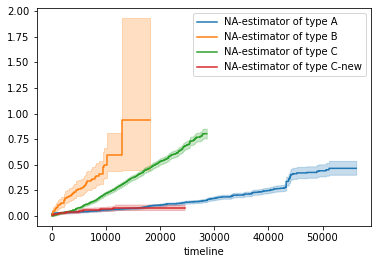

In [260]:
for typ in types:
    NAF(data_types[typ],typ).plot(ci_show=True)

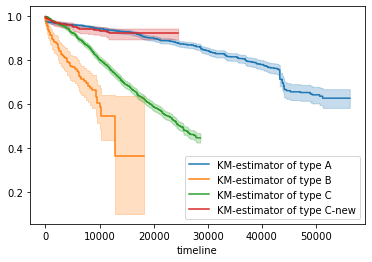

In [261]:
for typ in types:
    KMF(data_types[typ],typ).plot(ci_show=True)

### 2. Parametric models

In [262]:
parametric_models = ['Exponential', 'Weibull', 'LogNormal']
dict_model = {}
for i,model in enumerate(parametric_models):
    dict_model[model] = i

In [263]:
def models(data_type):
    T,d=time_sticker(data_type)
    T[T==0]=1e-6 # Avoid divising by zero.
    exp_model = ExponentialFitter(alpha=alpha).fit(T,d)
    wb_model = WeibullFitter(alpha=alpha).fit(T,d)
    lognorm_model = LogNormalFitter(alpha=alpha).fit(T,d)
    return exp_model,wb_model,lognorm_model

In [268]:
def R_plot(typ,model): # We visualize if the model "model' can fit the data of type "typ"
    m = models(data_types[typ])[dict_model[model]]
    m.survival_function_.plot()
    KMF(data_types[typ],typ).plot()
    plt.legend((model + ' model', 'KM-estimator'))
    plt.ylabel('Reliability function')
    plt.xlabel('Timeline')
    plt.title('Type ' + typ + ' data')

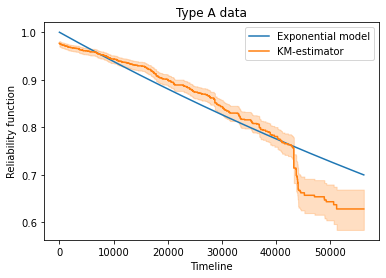

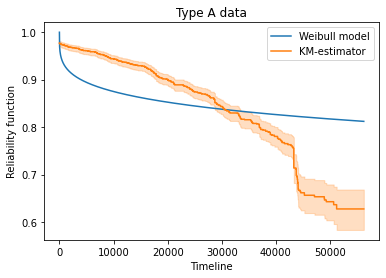

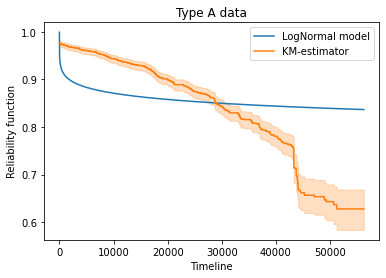

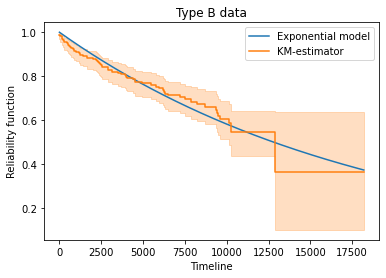

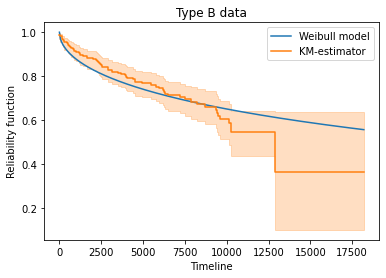

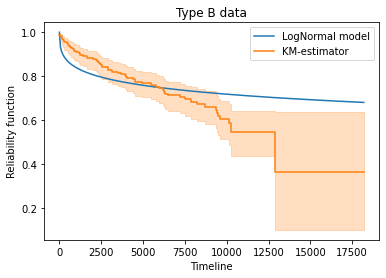

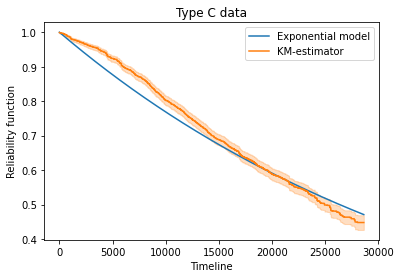

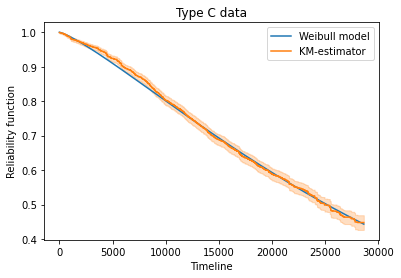

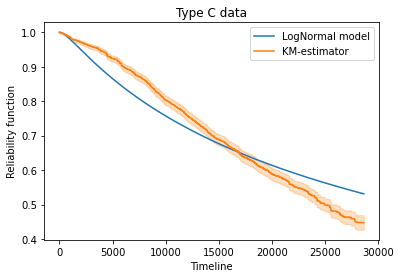

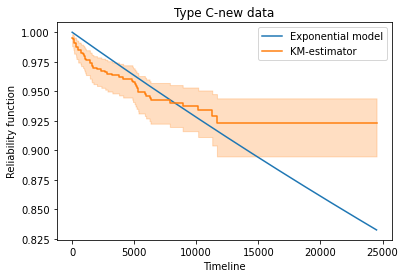

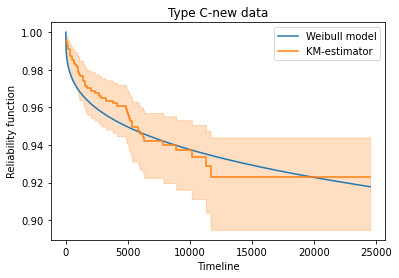

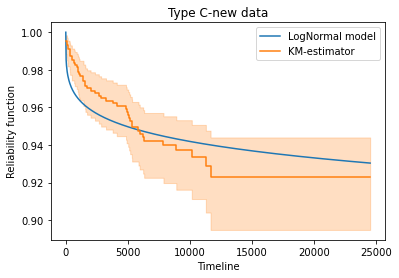

In [271]:
for typ in types:
    for model in parametric_models:
        R_plot(typ,model)

In [267]:
def best_model(models=parametric_models):
    return 0